## Ver.2  
- Ver.1보다 epoch을 늘렸음
- 모델의 generality를 높이기 위해 랜덤하게 이미지를 반전시키고 변형을 적용 (RandFlipd, RandAffined)
- 이미지에 Gaussian noise, sharpening을 추가 (RandGaussianNoised, RandGaussianSharpend)
- Ver.1보다 best mean dice는 낮아졌지만 validation set과 test set에 대해서는 분석 결과가 향상

# Image segmentation (3D UNET)


In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel]"
!python -c "import matplotlib" || pip install -q matplotlib

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     |████████████████████████████████| 1.0 MB 10.2 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path0 = '/content/drive/MyDrive/data/brats18_train/brats18_train'
dpiv = 80

In [4]:
from monai.transforms import *
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.utils import first

from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.inferers import sliding_window_inference
from monai.networks.layers import Norm

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import os
import glob

In [5]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

print(device)

cuda:0


In [6]:
path_list = glob.glob(os.path.join(path0,'Brats18*'))
len(path_list)

100

### data split (train/valid)

In [7]:
train_ind = np.arange(0,80)
data_dicts = [
    {
        "image": os.path.join(path_list[idx],
                                    "t1ce.nii.gz"),
        "label": os.path.join(path_list[idx],
                                    "seg.nii.gz"),
    }
    for idx in train_ind
]
train_files =  data_dicts

In [8]:
valid_ind = np.arange(80,100)
data_dicts = [
    {
        "image": os.path.join(path_list[idx],
                                    "t1ce.nii.gz"),
        "label": os.path.join(path_list[idx],
                                    "seg.nii.gz"),
    }
    for idx in valid_ind
]
valid_files =  data_dicts

In [9]:
train_transforms = Compose(
    [
      LoadImaged(keys=("image","label")),
      AddChanneld(keys=("image","label")),
      CenterSpatialCropd(keys=["image", "label"], roi_size=[192, 192, 96]),
      NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
      RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
      RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
      RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
      RandBiasFieldd(keys="image", degree=3, coeff_range=(0.0, 0.1)),
      RandGaussianNoised(keys="image", prob=0.3, mean=0.0, std=0.1),
      RandGaussianSharpend(keys="image", prob = 0.3),
      RandAffined(keys="image", prob=0.3, shear_range=(0.2,  0.2)),
      ToTensord(keys=["image", "label"]),
    ]
)
      
valid_transforms = Compose(
    [
      LoadImaged(keys=("image","label")),
      AddChanneld(keys=("image","label")),
      NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
      ToTensord(keys=["image", "label"]),
    ]
)

/usr/local/lib/python3.7/dist-packages/monai/utils/deprecate_utils.py:110: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


In [10]:
train_ds = Dataset(data = train_files, transform = train_transforms)
train_loader = DataLoader(train_ds,batch_size = 2)

In [11]:
valid_ds = Dataset(data = valid_files, transform = valid_transforms)
valid_loader = DataLoader(valid_ds,batch_size = 1)

- check transformation

(2, 1, 192, 192, 96)
(2, 1, 192, 192, 96)


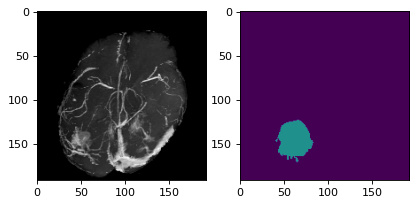

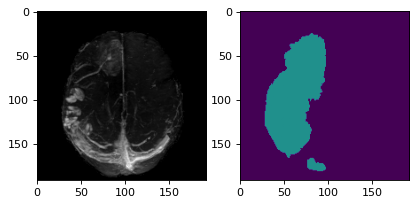

In [12]:
cnt = 0
for data in train_loader:
  print(data["image"].shape)
  print(data["label"].shape)

  for n in range(0,len(data["image"])):
    plt.figure(dpi=dpiv)
    plt.subplot(121)
    plt.imshow(np.transpose(np.max(data["image"][n,0,:,:,:].numpy(),axis=2),(1,0)),cmap='gray')

    label = (data["label"]==1).type(torch.FloatTensor) + (data["label"]==2).type(torch.FloatTensor) + (data["label"]==4).type(torch.FloatTensor) 
    plt.subplot(122)
    plt.imshow(np.transpose(np.max(label[n,0,:,:,:].numpy(),axis=2),(1,0)),vmin=0,vmax=2)
    plt.show()

  break


# Model

In [13]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)


/usr/local/lib/python3.7/dist-packages/monai/utils/deprecate_utils.py:222: FutureWarning: monai.networks.nets.unet UNet.__init__:dimensions: Argument `dimensions` has been deprecated since version 0.6. Please use `spatial_dims` instead.
  warn_deprecated(argname, msg, warning_category)
/usr/local/lib/python3.7/dist-packages/monai/networks/nets/unet.py:139: UserWarning: `len(strides) > len(channels) - 1`, the last 1 values of strides will not be used.
  warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")


# Train

----------
epoch 1/200
epoch 1 average loss: 0.6038
----------
epoch 2/200
epoch 2 average loss: 0.5854
----------
epoch 3/200
epoch 3 average loss: 0.5732
----------
epoch 4/200
epoch 4 average loss: 0.5630
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA03_375_1/t1ce.nii.gz']


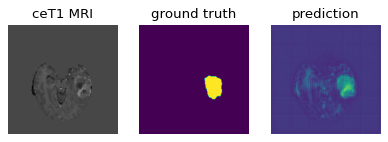

saved new best metric model
current epoch: 4 current mean dice: 0.4581
best mean dice: 0.4581 at epoch: 4
----------
epoch 5/200
epoch 5 average loss: 0.5540
----------
epoch 6/200
epoch 6 average loss: 0.5460
----------
epoch 7/200
epoch 7 average loss: 0.5370
----------
epoch 8/200
epoch 8 average loss: 0.5279
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA08_162_1/t1ce.nii.gz']


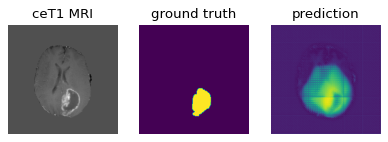

saved new best metric model
current epoch: 8 current mean dice: 0.4868
best mean dice: 0.4868 at epoch: 8
----------
epoch 9/200
epoch 9 average loss: 0.5185
----------
epoch 10/200
epoch 10 average loss: 0.5067
----------
epoch 11/200
epoch 11 average loss: 0.4946
----------
epoch 12/200
epoch 12 average loss: 0.4807
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA08_162_1/t1ce.nii.gz']


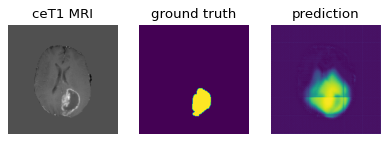

saved new best metric model
current epoch: 12 current mean dice: 0.5240
best mean dice: 0.5240 at epoch: 12
----------
epoch 13/200
epoch 13 average loss: 0.4725
----------
epoch 14/200
epoch 14 average loss: 0.4489
----------
epoch 15/200
epoch 15 average loss: 0.4340
----------
epoch 16/200
epoch 16 average loss: 0.4217
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA05_277_1/t1ce.nii.gz']


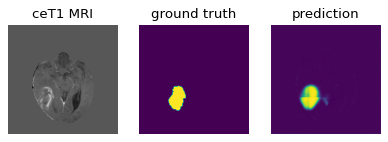

saved new best metric model
current epoch: 16 current mean dice: 0.5823
best mean dice: 0.5823 at epoch: 16
----------
epoch 17/200
epoch 17 average loss: 0.4030
----------
epoch 18/200
epoch 18 average loss: 0.3793
----------
epoch 19/200
epoch 19 average loss: 0.3642
----------
epoch 20/200
epoch 20 average loss: 0.3473
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA08_319_1/t1ce.nii.gz']


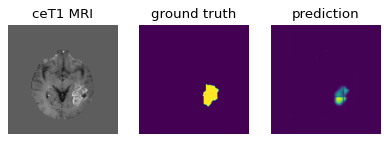

saved new best metric model
current epoch: 20 current mean dice: 0.5907
best mean dice: 0.5907 at epoch: 20
----------
epoch 21/200
epoch 21 average loss: 0.3308
----------
epoch 22/200
epoch 22 average loss: 0.3050
----------
epoch 23/200
epoch 23 average loss: 0.2933
----------
epoch 24/200
epoch 24 average loss: 0.2753
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA06_332_1/t1ce.nii.gz']


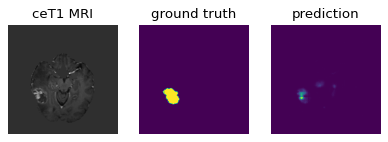

saved new best metric model
current epoch: 24 current mean dice: 0.6574
best mean dice: 0.6574 at epoch: 24
----------
epoch 25/200
epoch 25 average loss: 0.2484
----------
epoch 26/200
epoch 26 average loss: 0.2342
----------
epoch 27/200
epoch 27 average loss: 0.2202
----------
epoch 28/200
epoch 28 average loss: 0.2278
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA06_165_1/t1ce.nii.gz']


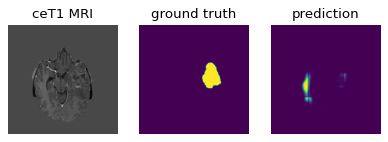

saved new best metric model
current epoch: 28 current mean dice: 0.7513
best mean dice: 0.7513 at epoch: 28
----------
epoch 29/200
epoch 29 average loss: 0.2153
----------
epoch 30/200
epoch 30 average loss: 0.1897
----------
epoch 31/200
epoch 31 average loss: 0.1896
----------
epoch 32/200
epoch 32 average loss: 0.1774
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA06_332_1/t1ce.nii.gz']


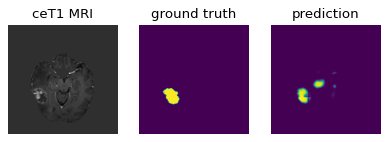

saved new best metric model
current epoch: 32 current mean dice: 0.7592
best mean dice: 0.7592 at epoch: 32
----------
epoch 33/200
epoch 33 average loss: 0.1781
----------
epoch 34/200
epoch 34 average loss: 0.1719
----------
epoch 35/200
epoch 35 average loss: 0.1707
----------
epoch 36/200
epoch 36 average loss: 0.1635
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA05_444_1/t1ce.nii.gz']


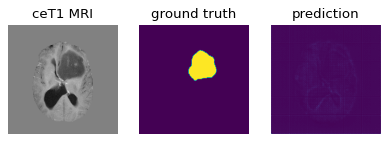

current epoch: 36 current mean dice: 0.7166
best mean dice: 0.7592 at epoch: 32
----------
epoch 37/200
epoch 37 average loss: 0.1793
----------
epoch 38/200
epoch 38 average loss: 0.1684
----------
epoch 39/200
epoch 39 average loss: 0.1612
----------
epoch 40/200
epoch 40 average loss: 0.1496
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA04_437_1/t1ce.nii.gz']


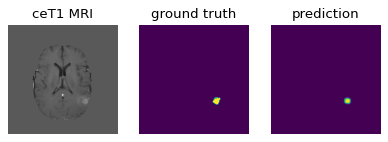

current epoch: 40 current mean dice: 0.7449
best mean dice: 0.7592 at epoch: 32
----------
epoch 41/200
epoch 41 average loss: 0.1495
----------
epoch 42/200
epoch 42 average loss: 0.1363
----------
epoch 43/200
epoch 43 average loss: 0.1467
----------
epoch 44/200
epoch 44 average loss: 0.1356
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA05_444_1/t1ce.nii.gz']


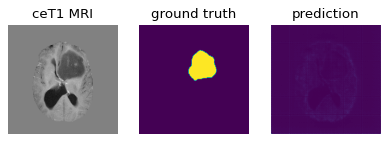

current epoch: 44 current mean dice: 0.7260
best mean dice: 0.7592 at epoch: 32
----------
epoch 45/200
epoch 45 average loss: 0.1443
----------
epoch 46/200
epoch 46 average loss: 0.1350
----------
epoch 47/200
epoch 47 average loss: 0.1334
----------
epoch 48/200
epoch 48 average loss: 0.1492
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA03_257_1/t1ce.nii.gz']


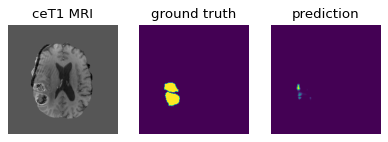

current epoch: 48 current mean dice: 0.7371
best mean dice: 0.7592 at epoch: 32
----------
epoch 49/200
epoch 49 average loss: 0.1259
----------
epoch 50/200
epoch 50 average loss: 0.1290
----------
epoch 51/200
epoch 51 average loss: 0.1196
----------
epoch 52/200
epoch 52 average loss: 0.1326
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA04_111_1/t1ce.nii.gz']


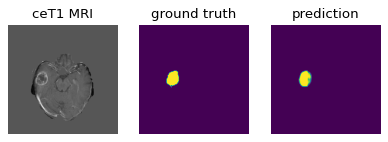

current epoch: 52 current mean dice: 0.7465
best mean dice: 0.7592 at epoch: 32
----------
epoch 53/200
epoch 53 average loss: 0.1308
----------
epoch 54/200
epoch 54 average loss: 0.1230
----------
epoch 55/200
epoch 55 average loss: 0.1243
----------
epoch 56/200
epoch 56 average loss: 0.1142
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA05_444_1/t1ce.nii.gz']


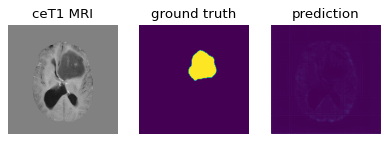

current epoch: 56 current mean dice: 0.7419
best mean dice: 0.7592 at epoch: 32
----------
epoch 57/200
epoch 57 average loss: 0.1175
----------
epoch 58/200
epoch 58 average loss: 0.1136
----------
epoch 59/200
epoch 59 average loss: 0.1119
----------
epoch 60/200
epoch 60 average loss: 0.1141
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA04_437_1/t1ce.nii.gz']


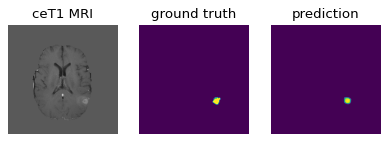

current epoch: 60 current mean dice: 0.7288
best mean dice: 0.7592 at epoch: 32
----------
epoch 61/200
epoch 61 average loss: 0.1071
----------
epoch 62/200
epoch 62 average loss: 0.1034
----------
epoch 63/200
epoch 63 average loss: 0.1161
----------
epoch 64/200
epoch 64 average loss: 0.1324
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA03_138_1/t1ce.nii.gz']


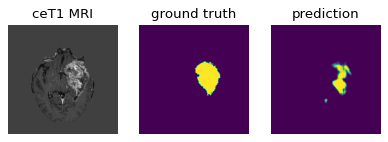

current epoch: 64 current mean dice: 0.7327
best mean dice: 0.7592 at epoch: 32
----------
epoch 65/200
epoch 65 average loss: 0.1093
----------
epoch 66/200
epoch 66 average loss: 0.1096
----------
epoch 67/200
epoch 67 average loss: 0.0964
----------
epoch 68/200
epoch 68 average loss: 0.1149
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA08_162_1/t1ce.nii.gz']


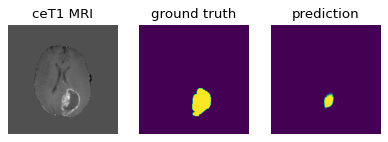

current epoch: 68 current mean dice: 0.7391
best mean dice: 0.7592 at epoch: 32
----------
epoch 69/200
epoch 69 average loss: 0.0968
----------
epoch 70/200
epoch 70 average loss: 0.1093
----------
epoch 71/200
epoch 71 average loss: 0.0978
----------
epoch 72/200
epoch 72 average loss: 0.0971
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA03_257_1/t1ce.nii.gz']


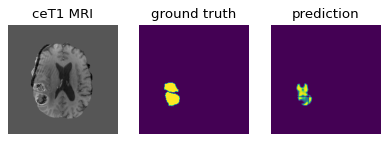

saved new best metric model
current epoch: 72 current mean dice: 0.7847
best mean dice: 0.7847 at epoch: 72
----------
epoch 73/200
epoch 73 average loss: 0.1108
----------
epoch 74/200
epoch 74 average loss: 0.1077
----------
epoch 75/200
epoch 75 average loss: 0.1006
----------
epoch 76/200
epoch 76 average loss: 0.1115
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA08_105_1/t1ce.nii.gz']


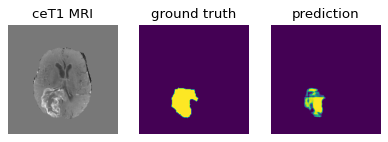

current epoch: 76 current mean dice: 0.7537
best mean dice: 0.7847 at epoch: 72
----------
epoch 77/200
epoch 77 average loss: 0.0962
----------
epoch 78/200
epoch 78 average loss: 0.0987
----------
epoch 79/200
epoch 79 average loss: 0.0927
----------
epoch 80/200
epoch 80 average loss: 0.0896
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA08_105_1/t1ce.nii.gz']


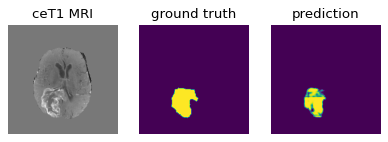

current epoch: 80 current mean dice: 0.7639
best mean dice: 0.7847 at epoch: 72
----------
epoch 81/200
epoch 81 average loss: 0.0935
----------
epoch 82/200
epoch 82 average loss: 0.1084
----------
epoch 83/200
epoch 83 average loss: 0.1156
----------
epoch 84/200
epoch 84 average loss: 0.1145
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA04_111_1/t1ce.nii.gz']


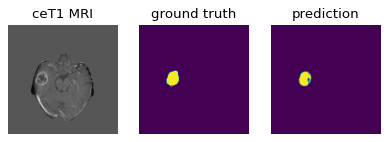

current epoch: 84 current mean dice: 0.7141
best mean dice: 0.7847 at epoch: 72
----------
epoch 85/200
epoch 85 average loss: 0.0947
----------
epoch 86/200
epoch 86 average loss: 0.0916
----------
epoch 87/200
epoch 87 average loss: 0.1001
----------
epoch 88/200
epoch 88 average loss: 0.1053
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA06_165_1/t1ce.nii.gz']


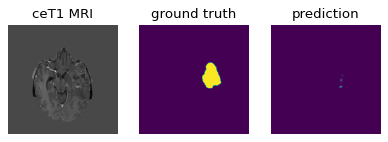

current epoch: 88 current mean dice: 0.7444
best mean dice: 0.7847 at epoch: 72
----------
epoch 89/200
epoch 89 average loss: 0.0934
----------
epoch 90/200
epoch 90 average loss: 0.0980
----------
epoch 91/200
epoch 91 average loss: 0.0913
----------
epoch 92/200
epoch 92 average loss: 0.1025
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA08_162_1/t1ce.nii.gz']


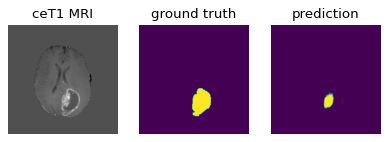

current epoch: 92 current mean dice: 0.7765
best mean dice: 0.7847 at epoch: 72
----------
epoch 93/200
epoch 93 average loss: 0.0930
----------
epoch 94/200
epoch 94 average loss: 0.0884
----------
epoch 95/200
epoch 95 average loss: 0.0999
----------
epoch 96/200
epoch 96 average loss: 0.1005
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA05_444_1/t1ce.nii.gz']


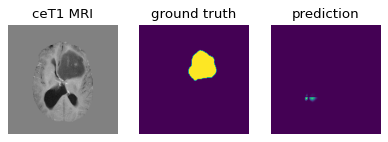

saved new best metric model
current epoch: 96 current mean dice: 0.7952
best mean dice: 0.7952 at epoch: 96
----------
epoch 97/200
epoch 97 average loss: 0.0871
----------
epoch 98/200
epoch 98 average loss: 0.0936
----------
epoch 99/200
epoch 99 average loss: 0.0890
----------
epoch 100/200
epoch 100 average loss: 0.1005
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA05_444_1/t1ce.nii.gz']


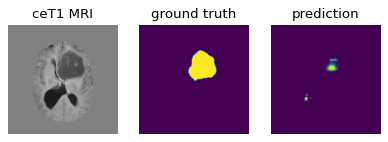

current epoch: 100 current mean dice: 0.7874
best mean dice: 0.7952 at epoch: 96
----------
epoch 101/200
epoch 101 average loss: 0.0898
----------
epoch 102/200
epoch 102 average loss: 0.0814
----------
epoch 103/200
epoch 103 average loss: 0.0924
----------
epoch 104/200
epoch 104 average loss: 0.0844
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA08_234_1/t1ce.nii.gz']


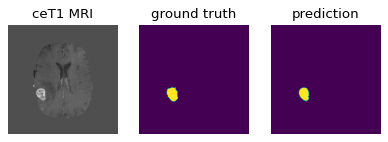

saved new best metric model
current epoch: 104 current mean dice: 0.8039
best mean dice: 0.8039 at epoch: 104
----------
epoch 105/200
epoch 105 average loss: 0.0906
----------
epoch 106/200
epoch 106 average loss: 0.0836
----------
epoch 107/200
epoch 107 average loss: 0.0821
----------
epoch 108/200
epoch 108 average loss: 0.0774
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA06_211_1/t1ce.nii.gz']


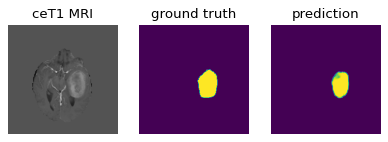

current epoch: 108 current mean dice: 0.7902
best mean dice: 0.8039 at epoch: 104
----------
epoch 109/200
epoch 109 average loss: 0.0876
----------
epoch 110/200
epoch 110 average loss: 0.0783
----------
epoch 111/200
epoch 111 average loss: 0.0824
----------
epoch 112/200
epoch 112 average loss: 0.0908
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA08_319_1/t1ce.nii.gz']


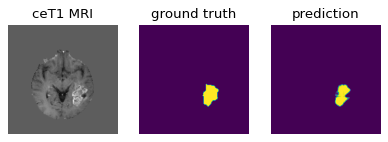

current epoch: 112 current mean dice: 0.7877
best mean dice: 0.8039 at epoch: 104
----------
epoch 113/200
epoch 113 average loss: 0.0953
----------
epoch 114/200
epoch 114 average loss: 0.0750
----------
epoch 115/200
epoch 115 average loss: 0.0766
----------
epoch 116/200
epoch 116 average loss: 0.0900
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA05_444_1/t1ce.nii.gz']


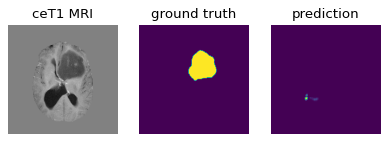

current epoch: 116 current mean dice: 0.7932
best mean dice: 0.8039 at epoch: 104
----------
epoch 117/200
epoch 117 average loss: 0.0839
----------
epoch 118/200
epoch 118 average loss: 0.0811
----------
epoch 119/200
epoch 119 average loss: 0.0749
----------
epoch 120/200
epoch 120 average loss: 0.0810
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA03_474_1/t1ce.nii.gz']


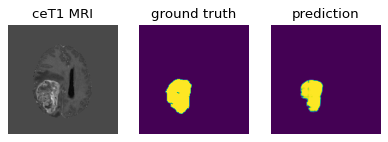

current epoch: 120 current mean dice: 0.7851
best mean dice: 0.8039 at epoch: 104
----------
epoch 121/200
epoch 121 average loss: 0.0787
----------
epoch 122/200
epoch 122 average loss: 0.0824
----------
epoch 123/200
epoch 123 average loss: 0.0862
----------
epoch 124/200
epoch 124 average loss: 0.0803
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA06_332_1/t1ce.nii.gz']


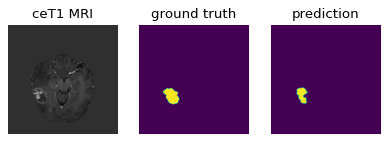

current epoch: 124 current mean dice: 0.8015
best mean dice: 0.8039 at epoch: 104
----------
epoch 125/200
epoch 125 average loss: 0.0786
----------
epoch 126/200
epoch 126 average loss: 0.0753
----------
epoch 127/200
epoch 127 average loss: 0.0829
----------
epoch 128/200
epoch 128 average loss: 0.0885
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA03_474_1/t1ce.nii.gz']


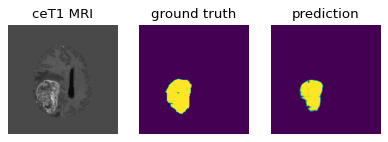

current epoch: 128 current mean dice: 0.7720
best mean dice: 0.8039 at epoch: 104
----------
epoch 129/200
epoch 129 average loss: 0.0732
----------
epoch 130/200
epoch 130 average loss: 0.0761
----------
epoch 131/200
epoch 131 average loss: 0.0783
----------
epoch 132/200
epoch 132 average loss: 0.0842
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA06_211_1/t1ce.nii.gz']


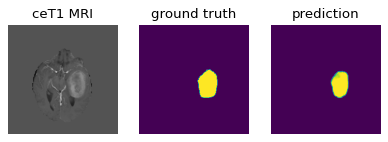

current epoch: 132 current mean dice: 0.8002
best mean dice: 0.8039 at epoch: 104
----------
epoch 133/200
epoch 133 average loss: 0.0804
----------
epoch 134/200
epoch 134 average loss: 0.0714
----------
epoch 135/200
epoch 135 average loss: 0.0768
----------
epoch 136/200
epoch 136 average loss: 0.0879
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA04_437_1/t1ce.nii.gz']


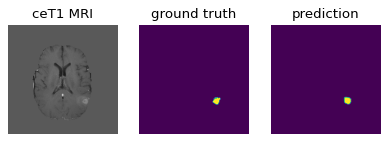

current epoch: 136 current mean dice: 0.7591
best mean dice: 0.8039 at epoch: 104
----------
epoch 137/200
epoch 137 average loss: 0.0734
----------
epoch 138/200
epoch 138 average loss: 0.0777
----------
epoch 139/200
epoch 139 average loss: 0.0755
----------
epoch 140/200
epoch 140 average loss: 0.0734
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA06_211_1/t1ce.nii.gz']


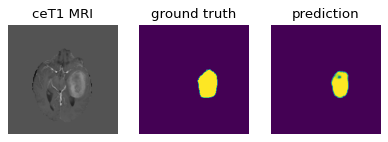

saved new best metric model
current epoch: 140 current mean dice: 0.8047
best mean dice: 0.8047 at epoch: 140
----------
epoch 141/200
epoch 141 average loss: 0.0798
----------
epoch 142/200
epoch 142 average loss: 0.0699
----------
epoch 143/200
epoch 143 average loss: 0.0737
----------
epoch 144/200
epoch 144 average loss: 0.0849
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA08_234_1/t1ce.nii.gz']


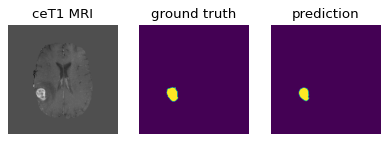

saved new best metric model
current epoch: 144 current mean dice: 0.8227
best mean dice: 0.8227 at epoch: 144
----------
epoch 145/200
epoch 145 average loss: 0.0730
----------
epoch 146/200
epoch 146 average loss: 0.0734
----------
epoch 147/200
epoch 147 average loss: 0.0783
----------
epoch 148/200
epoch 148 average loss: 0.0732
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA04_437_1/t1ce.nii.gz']


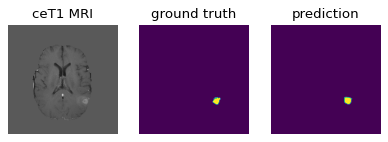

current epoch: 148 current mean dice: 0.7939
best mean dice: 0.8227 at epoch: 144
----------
epoch 149/200
epoch 149 average loss: 0.0774
----------
epoch 150/200
epoch 150 average loss: 0.0780
----------
epoch 151/200
epoch 151 average loss: 0.0661
----------
epoch 152/200
epoch 152 average loss: 0.0799
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA03_296_1/t1ce.nii.gz']


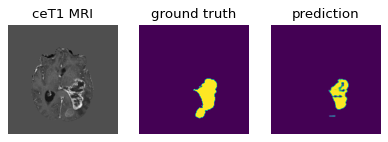

current epoch: 152 current mean dice: 0.7854
best mean dice: 0.8227 at epoch: 144
----------
epoch 153/200
epoch 153 average loss: 0.0812
----------
epoch 154/200
epoch 154 average loss: 0.0794
----------
epoch 155/200
epoch 155 average loss: 0.0755
----------
epoch 156/200
epoch 156 average loss: 0.0750
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA05_277_1/t1ce.nii.gz']


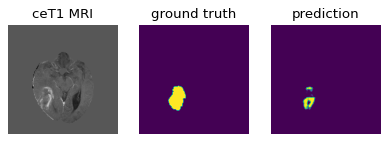

current epoch: 156 current mean dice: 0.7713
best mean dice: 0.8227 at epoch: 144
----------
epoch 157/200
epoch 157 average loss: 0.0758
----------
epoch 158/200
epoch 158 average loss: 0.0835
----------
epoch 159/200
epoch 159 average loss: 0.0832
----------
epoch 160/200
epoch 160 average loss: 0.0948
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA06_211_1/t1ce.nii.gz']


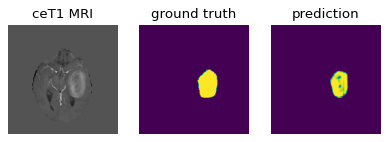

current epoch: 160 current mean dice: 0.8116
best mean dice: 0.8227 at epoch: 144
----------
epoch 161/200
epoch 161 average loss: 0.0820
----------
epoch 162/200
epoch 162 average loss: 0.0731
----------
epoch 163/200
epoch 163 average loss: 0.0800
----------
epoch 164/200
epoch 164 average loss: 0.0767
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA06_332_1/t1ce.nii.gz']


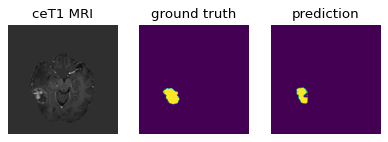

current epoch: 164 current mean dice: 0.7920
best mean dice: 0.8227 at epoch: 144
----------
epoch 165/200
epoch 165 average loss: 0.0853
----------
epoch 166/200
epoch 166 average loss: 0.0990
----------
epoch 167/200
epoch 167 average loss: 0.0816
----------
epoch 168/200
epoch 168 average loss: 0.0803
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA03_296_1/t1ce.nii.gz']


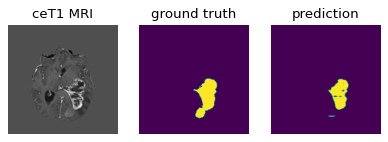

saved new best metric model
current epoch: 168 current mean dice: 0.8233
best mean dice: 0.8233 at epoch: 168
----------
epoch 169/200
epoch 169 average loss: 0.0779
----------
epoch 170/200
epoch 170 average loss: 0.0818
----------
epoch 171/200
epoch 171 average loss: 0.0773
----------
epoch 172/200
epoch 172 average loss: 0.0717
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA03_375_1/t1ce.nii.gz']


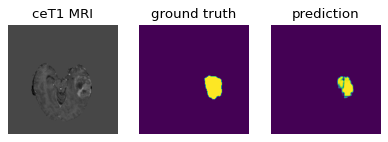

current epoch: 172 current mean dice: 0.8212
best mean dice: 0.8233 at epoch: 168
----------
epoch 173/200
epoch 173 average loss: 0.0690
----------
epoch 174/200
epoch 174 average loss: 0.0747
----------
epoch 175/200
epoch 175 average loss: 0.0732
----------
epoch 176/200
epoch 176 average loss: 0.0592
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA08_105_1/t1ce.nii.gz']


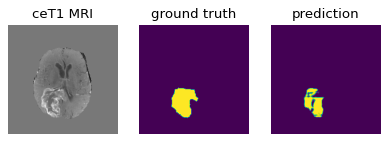

current epoch: 176 current mean dice: 0.8070
best mean dice: 0.8233 at epoch: 168
----------
epoch 177/200
epoch 177 average loss: 0.0697
----------
epoch 178/200
epoch 178 average loss: 0.0772
----------
epoch 179/200
epoch 179 average loss: 0.0693
----------
epoch 180/200
epoch 180 average loss: 0.0603
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA08_319_1/t1ce.nii.gz']


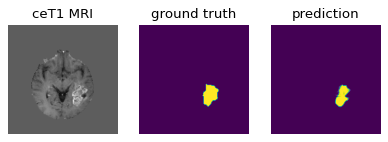

current epoch: 180 current mean dice: 0.8125
best mean dice: 0.8233 at epoch: 168
----------
epoch 181/200
epoch 181 average loss: 0.0687
----------
epoch 182/200
epoch 182 average loss: 0.0686
----------
epoch 183/200
epoch 183 average loss: 0.0763
----------
epoch 184/200
epoch 184 average loss: 0.0670
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA05_444_1/t1ce.nii.gz']


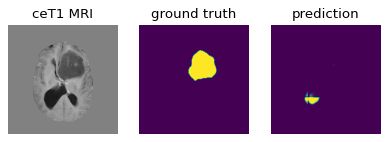

current epoch: 184 current mean dice: 0.7882
best mean dice: 0.8233 at epoch: 168
----------
epoch 185/200
epoch 185 average loss: 0.0697
----------
epoch 186/200
epoch 186 average loss: 0.0616
----------
epoch 187/200
epoch 187 average loss: 0.0613
----------
epoch 188/200
epoch 188 average loss: 0.0664
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA08_205_1/t1ce.nii.gz']


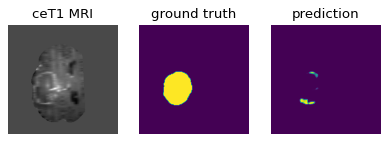

current epoch: 188 current mean dice: 0.8182
best mean dice: 0.8233 at epoch: 168
----------
epoch 189/200
epoch 189 average loss: 0.0689
----------
epoch 190/200
epoch 190 average loss: 0.0720
----------
epoch 191/200
epoch 191 average loss: 0.0659
----------
epoch 192/200
epoch 192 average loss: 0.0695
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA03_474_1/t1ce.nii.gz']


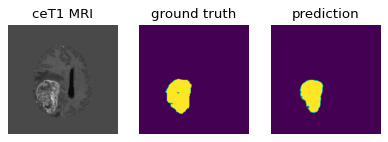

current epoch: 192 current mean dice: 0.8225
best mean dice: 0.8233 at epoch: 168
----------
epoch 193/200
epoch 193 average loss: 0.0723
----------
epoch 194/200
epoch 194 average loss: 0.0842
----------
epoch 195/200
epoch 195 average loss: 0.0695
----------
epoch 196/200
epoch 196 average loss: 0.0763
current epoch: 196 current mean dice: 0.8192
best mean dice: 0.8233 at epoch: 168
----------
epoch 197/200
epoch 197 average loss: 0.0705
----------
epoch 198/200
epoch 198 average loss: 0.0629
----------
epoch 199/200
epoch 199 average loss: 0.0698
----------
epoch 200/200
epoch 200 average loss: 0.0728
['/content/drive/MyDrive/data/brats18_train/brats18_train/Brats18_TCIA08_105_1/t1ce.nii.gz']


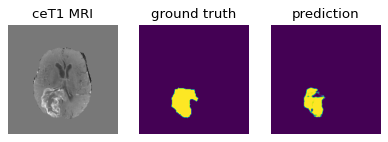

current epoch: 200 current mean dice: 0.8108
best mean dice: 0.8233 at epoch: 168


In [14]:
root_dir = path0 # model will be saved in this folder

lr = 1e-4
max_epochs = 200
val_interval = 4
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

optimizer = torch.optim.Adam(model.parameters(), lr)

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"],
        )

        labels = (labels==1).type(torch.FloatTensor) + (labels==4).type(torch.FloatTensor)
        labels[labels>0] = 1
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
 
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            metric_sum = 0.0
            metric_count = 0
            disp_val_no = np.random.randint(len(valid_files))
            for val_data in valid_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"],
                )        

                val_labels = (val_labels==1).type(torch.FloatTensor) + (val_labels==4).type(torch.FloatTensor)
                val_labels[val_labels>0] = 1
                val_labels = val_labels.to(device)
                
                roi_size = (160, 160, 64)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model, overlap=0.75)
                val_loss = loss_function(val_outputs, val_labels)
                
                metric_count += 1
                metric_sum += (1-val_loss.sum().item())
                
                if metric_count == disp_val_no:
                  print(val_data['image_meta_dict']['filename_or_obj'])
                  zz = np.argmax(np.sum(np.sum(np.array(val_labels[0,0,:,:,:].cpu()),axis=1),axis=0))
                  val_preds = val_outputs.softmax(1)
                  plt.figure(dpi=dpiv)
                  plt.subplot(131)
                  plt.imshow(np.transpose(val_inputs[0,0,:,:,zz].cpu().numpy(),(1,0)),cmap='gray')
                  plt.axis('off')
                  plt.title('ceT1 MRI')
                  plt.subplot(132)
                  plt.imshow(np.transpose(val_labels[0,0,:,:,zz].cpu().numpy(),(1,0)))
                  plt.axis('off')
                  plt.title('ground truth')
                  plt.subplot(133)
                  plt.imshow(np.transpose(val_preds[0,1,:,:,zz].cpu().numpy(),(1,0)))
                  plt.axis('off')
                  plt.title('prediction')
                  plt.show()
                
            metric = metric_sum / metric_count
            metric_values.append(metric)
            
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, f"best_metric_model_epoch_{best_metric_epoch}.pth"))    
                print("saved new best metric model")
            
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}")

## plot the loss and metric

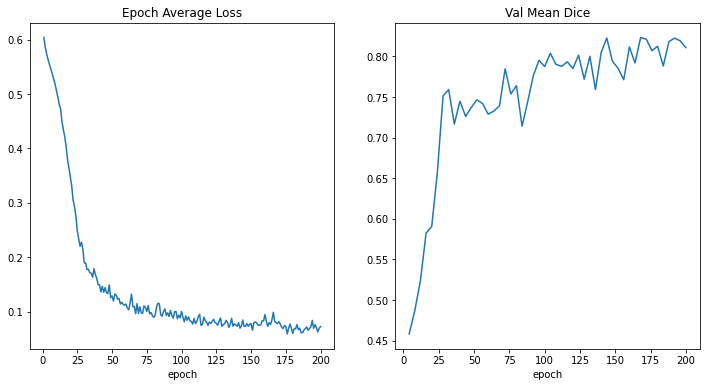

In [15]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()